# Predictive maintenance using machine learning
**Author:** Yohannes Kewani Gebrewahid 

## Project Overview
This notebook applies machine learning techniques to the **AI4I 2020 Predictive 
Maintenance Dataset**, which contains simulated sensor readings for industrial 
equipment. The dataset includes variables such as air temperature, process 
temperature, rotational speed, torque, and tool wear, along with labels 
indicating equipment failure modes.  

The main objective is to build models that can predict equipment failures 
before they happen. This supports **Industry 4.0** and **Industrial Analytics** 
by enabling data-driven maintenance planning, reducing downtime, and improving 
system efficiency.  

The notebook covers:
- Data preprocessing and exploratory analysis  
- Feature engineering  
- Training and evaluation of classification models  
- Insights on predictive maintenance for industrial systems


## Importing the required Libraries

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Importing the dataset and Preview

In [3]:

df = pd.read_csv("../../data/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Dataset Columns  

- **UDI**: Unique identifier for each record (not useful for prediction).  
- **Product ID**: Product code (categorical, may not directly indicate failures).  
- **Type**: Type of machine (categorical: L, M, H).  
- **Air temperature [K]**: Ambient air temperature around the machine.  
- **Process temperature [K]**: Internal temperature of the process.  
- **Rotational speed [rpm]**: Speed of the machine in revolutions per minute.  
- **Torque [Nm]**: Torque applied to the machine.  
- **Tool wear [min]**: Cumulative time a tool has been in use.  
- **Machine failure**: Target variable (1 = Failure, 0 = No Failure).  
- **TWF, HDF, PWF, OSF, RNF**: Specific types of failures (can be ignored if focusing only on `Machine failure`).  


In [4]:
df.Type.unique()

array(['M', 'L', 'H'], dtype=object)

In [5]:
df.UDI.unique()

array([    1,     2,     3, ...,  9998,  9999, 10000])

In [6]:
df['Product ID'].unique()

array(['M14860', 'L47181', 'L47182', ..., 'M24857', 'H39412', 'M24859'],
      dtype=object)

In [7]:
data1=df.drop(['UDI','Product ID','TWF','HDF','PWF','OSF','RNF'],axis='columns')
data1.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


## Data Cleaning

In [8]:
data1.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
dtype: int64

## Exploratory Data Analysis (EDA) 🔍

### Target Variable Distribution  

The dataset is **imbalanced** — most machines did not fail (`0`), while only a small fraction failed (`1`).  
This imbalance should be considered during model training, as it may affect the performance of classifiers.  


In [9]:
Machine_failure = data1[data1['Machine failure']==1]
Machine_failure.shape

(339, 7)

In [10]:
Machine_success = data1[data1['Machine failure']==0]
Machine_success.shape

(9661, 7)

In [11]:
df_means=data1.groupby('Machine failure').mean(numeric_only=True)
df_means


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Machine failure,,,,,
0,299.973999,309.995570,1540.260014,39.629655,106.693717
1,300.886431,310.290265,1496.486726,50.168142,143.781711


<function matplotlib.pyplot.show(close=None, block=None)>

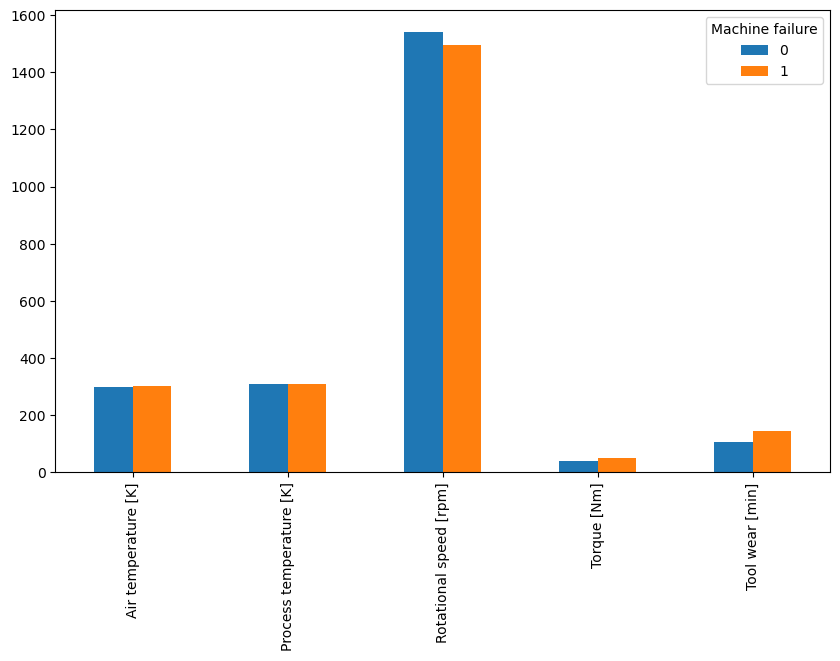

In [12]:
df_means.T.plot(kind = "bar", figsize=(10,6) )
plt.show

### Observations from the Mean Values

- **Air Temperature**: Slightly higher during failures, but the difference is very small.

- **Process Temperature**: Almost no difference between failure and no failure.

- **Rotational Speed**: Lower in failure cases, suggesting that reduced speed may contribute to failures.

- **Torque**: Substantially higher in failure cases → indicates a strong impact on machine breakdown.

- **Tool Wear**: Significantly higher when failures occur → one of the strongest predictors of machine failure.
#### Key Insights

- The strongest predictors of machine failure appear to be Torque and Tool Wear, as their averages increase sharply during failure cases.

- Rotational Speed shows a moderate effect, decreasing during failures.

- Air Temperature and Process Temperature show minimal differences, so their predictive power is likely weaker

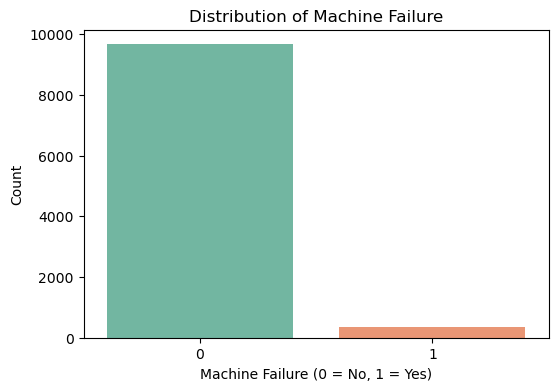

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x="Machine failure", hue="Machine failure", data=df, palette="Set2", legend=False)
plt.title("Distribution of Machine Failure")
plt.xlabel("Machine Failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


## Feature Distributions

In this section, we explore the distributions of the numeric and categorical features in the dataset. Understanding these distributions helps to identify patterns, potential outliers, and relationships between features and the target variable (`Machine failure`).

### Numeric Features
The numeric features include:
- **Air temperature [K]**: Ambient air temperature around the machine.
- **Process temperature [K]**: Temperature of the machine’s internal process.
- **Rotational speed [rpm]**: Machine speed in revolutions per minute.
- **Torque [Nm]**: Torque applied during operation.
- **Tool wear [min]**: Cumulative time the tool has been in use.

We visualize histograms to understand how the data is distributed, identify skewness, and detect potential outliers. Additionally, boxplots comparing these numeric features against `Machine failure` help to highlight which features differ significantly between failed and non-failed machines.

### Categorical Features
The main categorical feature is:
- **Type**: Machine type (L, M, H).

A bar chart is used to show the distribution of different machine types, which allows us to see whether certain types are more prone to failure.

### Insights
From the distributions, we can:
- Detect skewed or unevenly distributed features that may need transformation or normalization.
- Identify outliers that could affect model performance.
- Understand which features are most likely to influence `Machine failure` and may be strong predictors.


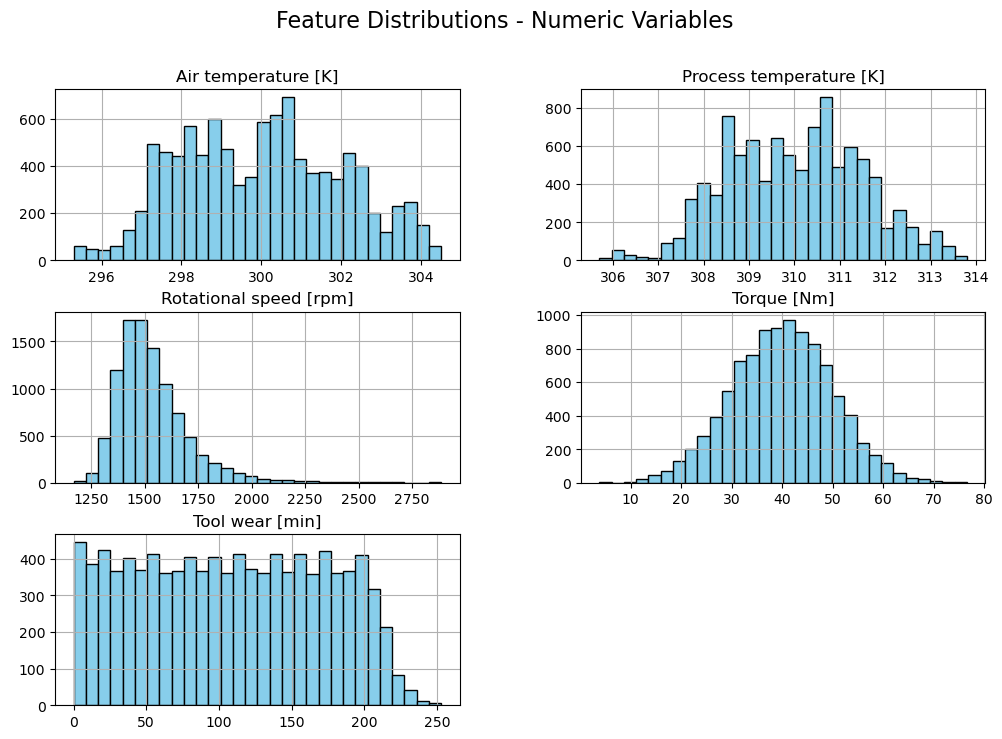

In [14]:
numeric_cols = ["Air temperature [K]", "Process temperature [K]", 
                "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

# Histograms for numeric features
data1[numeric_cols].hist(bins=30, figsize=(12,8), color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions - Numeric Variables", fontsize=16)
plt.show()


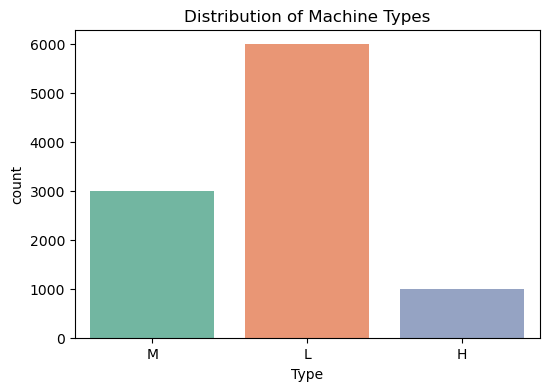

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x="Type", hue="Type", data=df, palette="Set2", legend=False)
plt.title("Distribution of Machine Types")
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_12976\3153098031.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Machine failure", y="Torque [Nm]", data=df, palette="Set2")


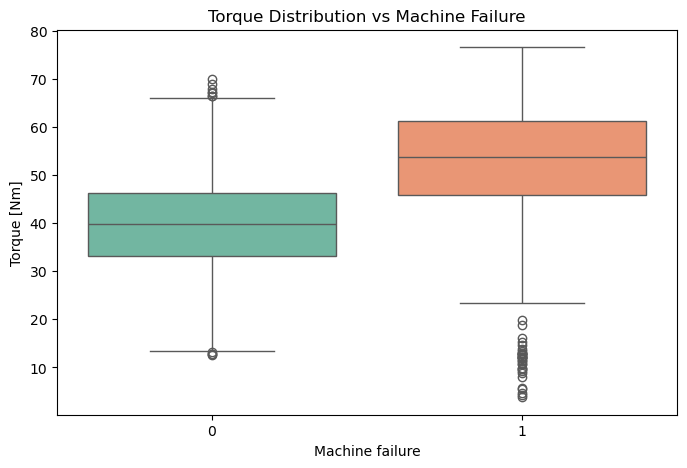

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Machine failure", y="Torque [Nm]", data=df, palette="Set2")
plt.title("Torque Distribution vs Machine Failure")
plt.show()


## Correlation Heatmap

A correlation heatmap shows the relationships between numeric features in the dataset.  
- Values close to **1** indicate a strong positive correlation.  
- Values close to **-1** indicate a strong negative correlation.  
- Values near **0** indicate little or no linear correlation.  

By examining the correlations, we can:
- Identify features that are strongly related to each other, which may indicate redundancy.
- Highlight features that are highly correlated with `Machine failure`, which could be important predictors for our model.


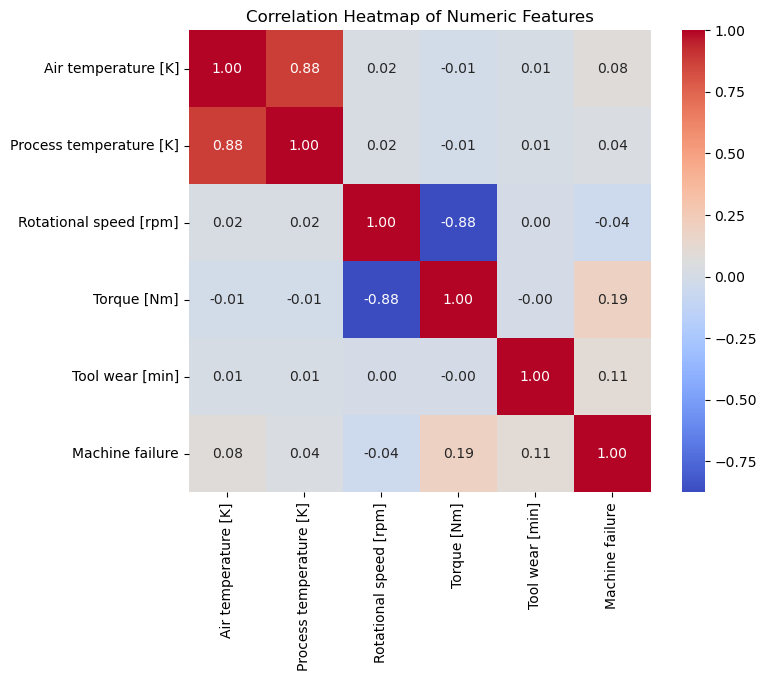

In [17]:

# Select numeric columns only
numeric_cols = ["Air temperature [K]", "Process temperature [K]", 
                "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]", "Machine failure"]

# Compute correlation matrix
corr_matrix = data1[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

**Checking for Null data set**

In [18]:
 print(df.isnull().values.any())

False


**Extracting Independent Varibales**

In [19]:
X = data1.drop('Machine failure', axis='columns').values
X

array([['M', 298.1, 308.6, 1551, 42.8, 0],
       ['L', 298.2, 308.7, 1408, 46.3, 3],
       ['L', 298.1, 308.5, 1498, 49.4, 5],
       ...,
       ['M', 299.0, 308.6, 1645, 33.4, 22],
       ['H', 299.0, 308.7, 1408, 48.5, 25],
       ['M', 299.0, 308.7, 1500, 40.2, 30]], dtype=object)

**Extracting Dependent variable**

In [20]:
y=data1['Machine failure'].values
y

array([0, 0, 0, ..., 0, 0, 0])

### Encoding Categorical Data

In [21]:
dummies = pd.get_dummies(data1.Type)
dummies.head()

,H,L,M
0,False,False,True
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False


In [22]:
dummies=dummies.astype(int)
dummies.head()

,H,L,M
0,0,0,1
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [26]:
data2 =pd.concat([dummies.drop('H', axis ='columns'),data1], axis ='columns')
data2.head()

,L,M,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,0,1,M,298.1,308.6,1551,42.8,0,0
1,1,0,L,298.2,308.7,1408,46.3,3,0
2,1,0,L,298.1,308.5,1498,49.4,5,0
3,1,0,L,298.2,308.6,1433,39.5,7,0
4,1,0,L,298.2,308.7,1408,40.0,9,0


In [27]:
data3= data2.drop('Type', axis='columns')
data3.head()

,L,M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,0,1,298.1,308.6,1551,42.8,0,0
1,1,0,298.2,308.7,1408,46.3,3,0
2,1,0,298.1,308.5,1498,49.4,5,0
3,1,0,298.2,308.6,1433,39.5,7,0
4,1,0,298.2,308.7,1408,40.0,9,0


In [28]:
X = data3.drop(['Machine failure'], axis='columns')
X.head()

,L,M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0,1,298.1,308.6,1551,42.8,0
1,1,0,298.2,308.7,1408,46.3,3
2,1,0,298.1,308.5,1498,49.4,5
3,1,0,298.2,308.6,1433,39.5,7
4,1,0,298.2,308.7,1408,40.0,9


In [29]:
y = data3['Machine failure']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Machine failure, dtype: int64

### Spliting Dataset into Training and Test set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train

,L,M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
9254,1,0,298.3,309.1,1616,31.1,195
1561,1,0,298.2,308.4,1388,53.8,137
1670,1,0,298.2,307.8,1528,31.1,194
6087,0,1,300.9,310.8,1599,33.0,7
6669,1,0,301.4,310.5,1571,33.9,208
...,...,...,...,...,...,...,...
5734,1,0,302.3,311.8,1369,56.2,208
5191,1,0,304.0,313.2,1416,46.0,128
5390,0,0,302.8,312.3,1483,47.2,223
860,0,0,296.1,306.9,1541,32.6,33


### Feature Scaling

In [98]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train[:,2:] = sc.fit_transform(X_train[:,2:])
# X_test[:,2:] = sc.transform(X_test[:,2:])

In [99]:
print(X_train)

      L  M  Air temperature [K]  Process temperature [K]  \
9254  1  0                298.3                    309.1   
1561  1  0                298.2                    308.4   
1670  1  0                298.2                    307.8   
6087  0  1                300.9                    310.8   
6669  1  0                301.4                    310.5   
...  .. ..                  ...                      ...   
5734  1  0                302.3                    311.8   
5191  1  0                304.0                    313.2   
5390  0  0                302.8                    312.3   
860   0  0                296.1                    306.9   
7270  1  0                300.2                    310.4   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
9254                    1616         31.1              195  
1561                    1388         53.8              137  
1670                    1528         31.1              194  
6087                    1599       

In [31]:
print(X_test)

      L  M  Air temperature [K]  Process temperature [K]  \
6252  1  0                300.8                    310.3   
4684  0  1                303.6                    311.8   
1731  0  1                298.3                    307.9   
4742  1  0                303.3                    311.3   
4521  1  0                302.4                    310.4   
...  .. ..                  ...                      ...   
6412  1  0                300.4                    310.0   
8285  1  0                298.9                    310.6   
7853  1  0                300.3                    311.7   
1095  1  0                296.9                    307.5   
6929  0  1                301.0                    311.6   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
6252                    1538         36.1              198  
4684                    1421         44.8              101  
1731                    1485         42.0              117  
4742                    1592       

In [32]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test,y_test)

0.12381638104541648

In [33]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv= ShuffleSplit(n_splits = 5, test_size =0.2, random_state =0)
cross_val_score(LinearRegression(),X,y,cv=cv)

array([0.12375192, 0.08589839, 0.11949669, 0.12319395, 0.11684183])

## Find best model using GridSearchCV

In [34]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                # 'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'svm': {
                      'model': svm.SVC(gamma='auto'),
                       'params':{
                           'kernel': ['rbf','linear'],
                           'C':[1,10,20]}},
              'random_forest':{
                        'model': RandomForestClassifier(), 
                        'params':{
                            'n_estimators': [1,5,10]}}  
    }

  
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    

KeyboardInterrupt: 

**Based on above results we can say that Random Forest with n_estimators of 5 gives the best score. Hence we will use that.**

In [35]:
rfc = RandomForestClassifier(n_estimators=5)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=5)

In [36]:
y_pred=rfc.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [37]:
rfc.score(X_test,y_test)

0.9815

### Test the model for 

In [41]:
def predict_failure(type,air_T,process_T,R_speed, Torque, Tool_wear):
    loc_index = np.where(X.columns ==type)[0][0]
    x = np.zeros(len(X.columns))
    x[2]=air_T
    x[3]=process_T
    x[4]=R_speed
    x[5]=Torque
    x[6]=Tool_wear
    if loc_index >= 0:
         x[loc_index]=1
    return rfc.predict([x])[0]

In [44]:
predict_failure('M',700, 500, 500,100,333 )

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


np.int64(1)

### Export the tested model to pickle file

In [47]:
import pickle
with open('Failure_prediction.pickle','wb') as f:
    pickle.dump(rfc, f)


### Export the column information to json file

In [49]:
import json
columns ={
    'data_columns':[col.lower() for col in X.columns]
}
with open('columns.json','w') as f:
    f.write(json.dumps(columns))